In [30]:
#where I learned the xgboost code
#https://www.kaggle.com/code/stuarthallows/using-xgboost-with-scikit-learn
#Get plaintext secrets
from configparser import ConfigParser
parser = ConfigParser()
_ = parser.read('secrets.cfg')
neo4j_useraccount = parser.get('my_data', 'neo4j_useraccount')
neo4j_password = parser.get('my_data', 'neo4j_password')


In [31]:
import pandas as pd
import configparser
import os

#sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, matthews_corrcoef
from sklearn.metrics import roc_curve,RocCurveDisplay,confusion_matrix

#Smote modules
from imblearn.over_sampling import SMOTE,BorderlineSMOTE


#import visualization libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz


#set settings for panda dataframes
pd.set_option('display.width', 0)
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', 50)

In [32]:
from graphdatascience import GraphDataScience

host = "bolt://172.17.0.2:7687"
user = neo4j_useraccount
password= neo4j_password

gds = GraphDataScience(host, auth=(user, password))

In [33]:
%%time
#Get all the processes
all_processes= gds.run_cypher("""
MATCH (p:Process)
RETURN p.CommandLine_length as CommandLine_length,p.network_degree as Network_degree,p.direct_children as Direct_children,p.ProcessGuid as ProcessGuid,p.numbers_of_executed_commands as Numbers_of_executed_commands,p.numbers_of_files_created as Numbers_of_files_created,p.malicious as Malicious
""") 

#all_processes.head()

CPU times: user 39.7 s, sys: 4.46 s, total: 44.1 s
Wall time: 52.6 s


In [34]:
# find the rows with NaN values
mask = all_processes.isna().any(axis=1)
rows_with_nan = all_processes[mask]

# print the rows with NaN values
#print(rows_with_nan)

In [35]:
#Fix the empty ones with 0
#it is only the CommandLine_length lets fill those with 0
#and change the names of the variables to x and y
df=all_processes.fillna(0)

In [36]:
#import libraries for running xgboost models
import xgboost as xgb


In [105]:
#Get the variables into x and y for readability
X=df[['CommandLine_length', 'Network_degree', 'Direct_children', 'Numbers_of_executed_commands', 'Numbers_of_files_created']]
y=df['Malicious']

In [106]:
%%time
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

CPU times: user 81.3 ms, sys: 3.95 ms, total: 85.2 ms
Wall time: 83.2 ms


In [107]:
%%time
# create the DMatrix objects for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


CPU times: user 277 ms, sys: 3.05 ms, total: 280 ms
Wall time: 138 ms


In [108]:
# set the parameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 4,
    'eta': 0.1
}


In [109]:
%%time
# train the XGBoost model
num_rounds = 100
model = xgb.train(params, dtrain, num_rounds)


CPU times: user 38.4 s, sys: 63.6 ms, total: 38.5 s
Wall time: 19.2 s


In [110]:
%%time
# make predictions on the test set
y_pred = model.predict(dtest)
#convert to a binary benign or malicious prediction
y_pred = [1 if pred > 0.5 else 0 for pred in y_pred]


CPU times: user 533 ms, sys: 10 µs, total: 533 ms
Wall time: 480 ms


In [111]:
# evaluate the performance of the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1score = 2*(precision * recall)/(precision + recall)
mcc = matthews_corrcoef(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("f1score: ", f1score)
print("mccscore:", mcc)

Accuracy:  0.9999970554112707
Precision:  1.0
Recall:  0.8
f1score:  0.888888888888889
mccscore: 0.8944258741233229


In [133]:
#hidden to be able to export to  pdf
#xgb.plot_tree(model, num_trees=model.best_iteration)

In [134]:
#hidden to be able to export to  pdf
#xgb.to_graphviz(model, num_trees=model.best_iteration)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

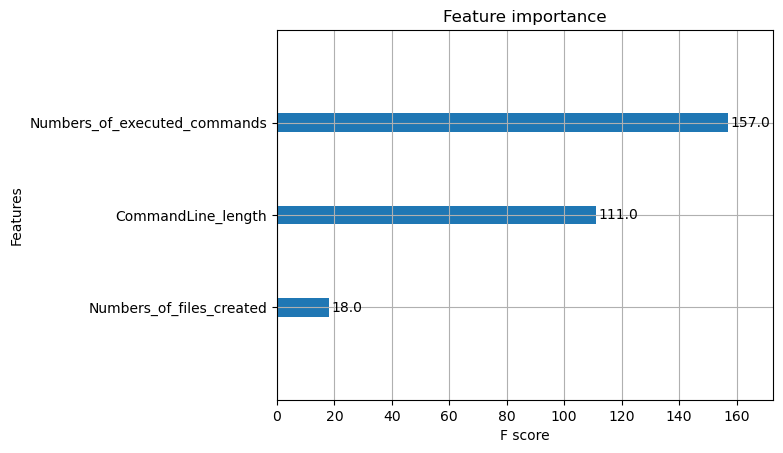

In [136]:
#hidden to be able to export to  pdf
xgb.plot_importance(model)

In [124]:
#BorderlineSMOTE
#since we have very few malicious events
smote_border = BorderlineSMOTE(random_state = 8,k_neighbors=2)
X_train_smote, y_train_smote = smote_border.fit_resample(X_train, y_train)

In [125]:
# create the DMatrix objects for XGBoost
dtrain = xgb.DMatrix(X_train_smote, label= y_train_smote)
dtest = xgb.DMatrix(X_test, label=y_test)


In [126]:
# set the parameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 4,
    'eta': 0.1
}


In [127]:
%%time
# train the XGBoost model
num_rounds = 100
model = xgb.train(params, dtrain, num_rounds)


CPU times: user 1min 32s, sys: 83.7 ms, total: 1min 32s
Wall time: 35.1 s


In [128]:
%%time
# make predictions on the test set
y_pred = model.predict(dtest)
y_pred = [1 if pred > 0.5 else 0 for pred in y_pred]


CPU times: user 692 ms, sys: 988 µs, total: 693 ms
Wall time: 591 ms


In [130]:
# evaluate the performance of the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1score = 2*(precision * recall)/(precision + recall)
mcc = matthews_corrcoef(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("f1score: ", f1score)
print("mccscore:", mcc)

Accuracy:  0.9999970554112707
Precision:  1.0
Recall:  0.8
f1score:  0.888888888888889
mccscore: 0.8944258741233229
